In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-zoomcamp-2024-competition/actual_matrix.csv
/kaggle/input/ml-zoomcamp-2024-competition/discounts_history.csv
/kaggle/input/ml-zoomcamp-2024-competition/price_history.csv
/kaggle/input/ml-zoomcamp-2024-competition/sample_submission.csv
/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv
/kaggle/input/ml-zoomcamp-2024-competition/markdowns.csv
/kaggle/input/ml-zoomcamp-2024-competition/online.csv
/kaggle/input/ml-zoomcamp-2024-competition/sales.csv
/kaggle/input/ml-zoomcamp-2024-competition/stores.csv
/kaggle/input/ml-zoomcamp-2024-competition/test.csv


In [71]:
sample_submission = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/sample_submission.csv")

In [72]:
sample_submission.head()

,row_id,quantity
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [73]:
import xgboost
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [74]:
sales = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/sales.csv")
online = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/online.csv")
markdown = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/markdowns.csv")
price_history = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/price_history.csv")
discount_history = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/discounts_history.csv")
actual_matrix = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/actual_matrix.csv")
catalog = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv")
stores = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/stores.csv")

In [75]:
# Merge sales and online data with suffixes to differentiate offline and online columns
sales_online_merged = pd.merge(sales, online, on=["date", "item_id", "store_id"], suffixes=('_offline', '_online'))

# Merge with markdowns using 'left' join to keep all sales data
sales_online_merged = pd.merge(sales_online_merged, markdown, on=["date", "item_id", "store_id"], how="left")

# Merge with price_history using 'left' join to keep all previous data
sales_online_merged = pd.merge(sales_online_merged, price_history, on=["date", "item_id", "store_id"], how="left")

# Merge with discount_history using 'left' join to keep all previous data
sales_online_merged = pd.merge(sales_online_merged, discount_history, on=["date", "item_id", "store_id"], how="left")

# Merge with actual_matrix to add product availability data
sales_online_merged = pd.merge(sales_online_merged, actual_matrix, on=["item_id", "store_id"], how="left", suffixes=('_sales', '_matrix'))

# Merge with catalog to add product details
sales_online_merged = pd.merge(sales_online_merged, catalog, on="item_id", how="left")

# Final merge with stores to add store-specific information and add suffix for store columns
final_merged = pd.merge(sales_online_merged, stores, on="store_id", how="left", suffixes=('', '_store'))

In [76]:
# Final merge with stores to add store-specific information and add suffix for store columns
final_merged = pd.merge(sales_online_merged, stores, on="store_id", how="left", suffixes=('', '_store'))

In [77]:
final_merged.isnull().sum() / final_merged.shape[0]

Unnamed: 0_offline         0.000000
date_sales                 0.000000
item_id                    0.000000
quantity_offline           0.000000
price_base_offline         0.000000
sum_total_offline          0.000000
store_id                   0.000000
Unnamed: 0_online          0.000000
quantity_online            0.000000
price_base_online          0.000000
sum_total_online           0.000000
Unnamed: 0_x               0.998193
normal_price               0.998193
price_x                    0.998193
quantity                   0.998193
Unnamed: 0_y               0.957946
price_y                    0.957946
code                       0.957946
Unnamed: 0_sales           0.732263
sale_price_before_promo    0.732263
sale_price_time_promo      0.732263
promo_type_code            0.736472
doc_id                     0.732263
number_disc_day            0.732263
Unnamed: 0_matrix          0.153054
date_matrix                0.153054
Unnamed: 0                 0.003460
dept_name                  0

In [78]:
final_merged.shape

(911148, 39)

## drop coulmns with > 0.5% of missing data and irrelevant dataset

In [79]:
final_merged.columns

Index(['Unnamed: 0_offline', 'date_sales', 'item_id', 'quantity_offline',
       'price_base_offline', 'sum_total_offline', 'store_id',
       'Unnamed: 0_online', 'quantity_online', 'price_base_online',
       'sum_total_online', 'Unnamed: 0_x', 'normal_price', 'price_x',
       'quantity', 'Unnamed: 0_y', 'price_y', 'code', 'Unnamed: 0_sales',
       'sale_price_before_promo', 'sale_price_time_promo', 'promo_type_code',
       'doc_id', 'number_disc_day', 'Unnamed: 0_matrix', 'date_matrix',
       'Unnamed: 0', 'dept_name', 'class_name', 'subclass_name', 'item_type',
       'weight_volume', 'weight_netto', 'fatness', 'Unnamed: 0_store',
       'division', 'format', 'city', 'area'],
      dtype='object')

In [80]:
# first remove the unnamed coulmn
final_merged = final_merged.drop(columns=["Unnamed: 0_x", "Unnamed: 0", "Unnamed: 0_matrix", 'Unnamed: 0_offline','Unnamed: 0_online', 'Unnamed: 0_y', 'Unnamed: 0_store', 'Unnamed: 0_sales'])

In [81]:
final_merged.columns

Index(['date_sales', 'item_id', 'quantity_offline', 'price_base_offline',
       'sum_total_offline', 'store_id', 'quantity_online', 'price_base_online',
       'sum_total_online', 'normal_price', 'price_x', 'quantity', 'price_y',
       'code', 'sale_price_before_promo', 'sale_price_time_promo',
       'promo_type_code', 'doc_id', 'number_disc_day', 'date_matrix',
       'dept_name', 'class_name', 'subclass_name', 'item_type',
       'weight_volume', 'weight_netto', 'fatness', 'division', 'format',
       'city', 'area'],
      dtype='object')

In [82]:
# drop columns with > 50% missing values
final_merged = final_merged.drop(columns=['normal_price', 'price_x', 'quantity', 'price_y',
       'code', 'sale_price_before_promo', 'sale_price_time_promo',
       'promo_type_code', 'doc_id', 'number_disc_day', "fatness"])

In [83]:
final_merged.isnull().sum() / final_merged.shape[0]

date_sales            0.000000
item_id               0.000000
quantity_offline      0.000000
price_base_offline    0.000000
sum_total_offline     0.000000
store_id              0.000000
quantity_online       0.000000
price_base_online     0.000000
sum_total_online      0.000000
date_matrix           0.153054
dept_name             0.003460
class_name            0.003460
subclass_name         0.003460
item_type             0.049190
weight_volume         0.268734
weight_netto          0.238220
division              0.000000
format                0.000000
city                  0.000000
area                  0.000000
dtype: float64

In [84]:
final_merged.tail()

,date_sales,item_id,quantity_offline,price_base_offline,sum_total_offline,store_id,quantity_online,price_base_online,sum_total_online,date_matrix,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,division,format,city,area
911143,2024-09-26,3d0a6d1afe26,4.000,69.90,279.60,4,2.000,51.37,102.74,2024-06-07,КОНСЕРВЫ МОЛОЧНЫЕ,МОЛОКО СГУЩЕННОЕ,МОЛОКО СГУЩЕННОЕ,Молочные,0.27,0.27,Div1,MaxiEuro,City3,1887
911144,2024-09-26,a10577439fbb,18.757,129.28,2424.99,4,1.850,128.86,238.39,2024-08-07,ОВОЩИ,НЕКОРНЕПЛОДЫ,ТОМАТЫ,Томаты,NaN,NaN,Div1,MaxiEuro,City3,1887
911145,2024-09-26,13d4259b0f09,2.446,287.11,702.28,4,1.142,250.34,285.89,2024-05-22,ФРУКТЫ,БАНАНЫ,БАНАНЫ,Бананы,NaN,NaN,Div1,MaxiEuro,City3,1887
911146,2024-09-26,1361d3af14b2,0.538,209.89,112.92,4,0.512,166.56,85.28,2024-07-15,ФРУКТЫ,ГРУШИ,ГРУШИ,Груши,NaN,NaN,Div1,MaxiEuro,City3,1887
911147,2024-09-26,87b794255afc,6.000,499.90,2999.40,4,1.000,421.53,421.53,2023-12-13,КОФЕ,КОФЕ РАСТВОРИМЫЙ,СТ/Б,Кофе,0.19,0.19,Div1,MaxiEuro,City3,1887


## Create the target column

In [85]:
# create a total quantity column which would be the y value
final_merged["total_quantity"] = final_merged["quantity_offline"] + final_merged["quantity_online"]

### Split the dataset

In [86]:
# Convert date column to datetime if it's not already
final_merged["date"] = pd.to_datetime(final_merged["date_sales"])

# Sort the data by date to ensure proper time order
final_merged = final_merged.sort_values(by="date")

# Calculate the index for 80% of the data
split_index = int(0.8 * len(final_merged))

# Split into training and test sets
train_set = final_merged.iloc[:split_index]
test_set = final_merged.iloc[split_index:]

In [87]:
train_set.duplicated().any(), test_set.duplicated().any()

(True, True)

In [88]:
train_set.shape, test_set.shape

((728918, 22), (182230, 22))

In [89]:
# Remove duplicates from train_set
train_set = train_set.drop_duplicates()

# Remove duplicates from test_set
test_set = test_set.drop_duplicates()

In [90]:
train_set.duplicated().any(), test_set.duplicated().any()

(False, False)

In [91]:
train_set.shape, test_set.shape

((724877, 22), (181726, 22))

## Check the distribution of the target variable

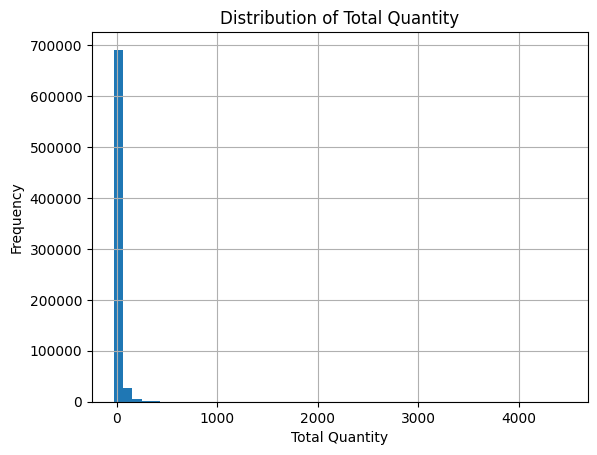

In [92]:
# check the distribution of the target coulmn
train_set["total_quantity"].hist(bins=50)
plt.title('Distribution of Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Frequency')
plt.show()

In [93]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_set["total_quantity"].quantile(0.25)
Q3 = train_set["total_quantity"].quantile(0.75)


IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
train_set = train_set[(train_set["total_quantity"] >= lower_bound) & 
                                     (train_set["total_quantity"] <= upper_bound) &
(train_set["total_quantity"] >= 0)]

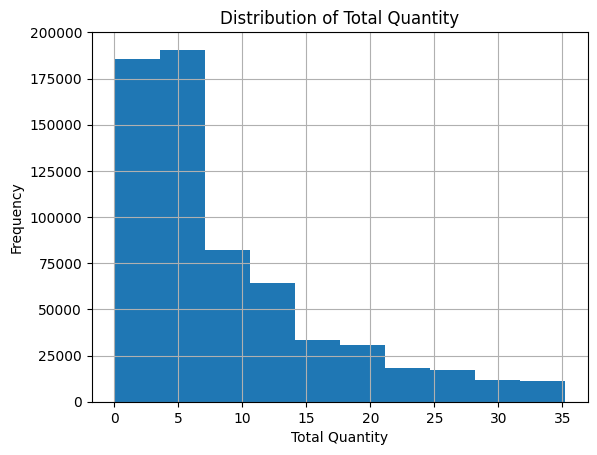

In [94]:
train_set["total_quantity"].hist(bins=10)
plt.title('Distribution of Total Quantity')
plt.xlabel('Total Quantity')
plt.ylabel('Frequency')
plt.show()

In [95]:
# # Apply log transformation (add 1 to avoid log(0) error)
# train_set["total_quantity"] = np.log1p(train_set["total_quantity"])

# # Plot histogram of transformed data (use the filtered dataset)
# train_set["total_quantity"].hist(bins=10)
# plt.title('Distribution of Log-Transformed Total Quantity')
# plt.xlabel('Log(1 + Total Quantity)')
# plt.ylabel('Frequency')
# plt.show()

## EDA 

In [96]:
train_set.describe()

,quantity_offline,price_base_offline,sum_total_offline,store_id,quantity_online,price_base_online,sum_total_online,weight_volume,weight_netto,area,total_quantity,date
count,645282.000000,645282.000000,645282.000000,645282.000000,645282.000000,645282.000000,645282.000000,478705.000000,498180.000000,645282.000000,645282.000000,645282
mean,6.971199,211.383606,1200.799343,1.482338,1.804226,149.546757,194.983606,1.496791,0.423032,1562.221596,8.775425,2023-08-19 08:32:57.896175360
min,-2.000000,-1637.810000,-956.000000,1.000000,0.002000,-113.960000,-341.880000,0.000010,0.000000,1500.000000,0.000000,2022-08-28 00:00:00
25%,2.000000,59.900000,199.740000,1.000000,1.000000,42.940000,59.880000,0.130000,0.125000,1500.000000,3.000000,2023-02-17 00:00:00
50%,4.000000,109.000000,482.895000,1.000000,1.000000,76.060000,107.810000,0.280000,0.250000,1500.000000,6.000000,2023-09-11 00:00:00
75%,9.934000,229.900000,1229.507500,1.000000,2.000000,168.377500,213.000000,0.500000,0.450000,1500.000000,12.000000,2024-02-20 00:00:00
max,35.008000,7999.900000,100798.600000,4.000000,33.000000,7048.180000,15390.000000,300.000000,13.600000,1887.000000,35.236000,2024-06-06 00:00:00
std,7.037584,288.808753,2219.249237,1.101983,1.707535,209.274740,283.558732,9.479140,0.580401,142.155767,7.654505,NaN


## There are some outliner in the dataset 
the quantity has negative value, same as price, sum_total

In [97]:
# remove outliner from the dataset
outliner_column = ["quantity_offline", "price_base_offline","sum_total_offline", "price_base_online", "sum_total_online", "total_quantity"]

for col in outliner_column:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    
    
    IQR = Q3 - Q1
    
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    train_set = train_set[(train_set[col] >= lower_bound) & 
                                         (train_set[col] <= upper_bound) &
    (train_set[col] >= 0)]

### correlation between variables

In [98]:
corrs = abs(train_set.select_dtypes(include='number').corr()['total_quantity']).sort_values(ascending = False)

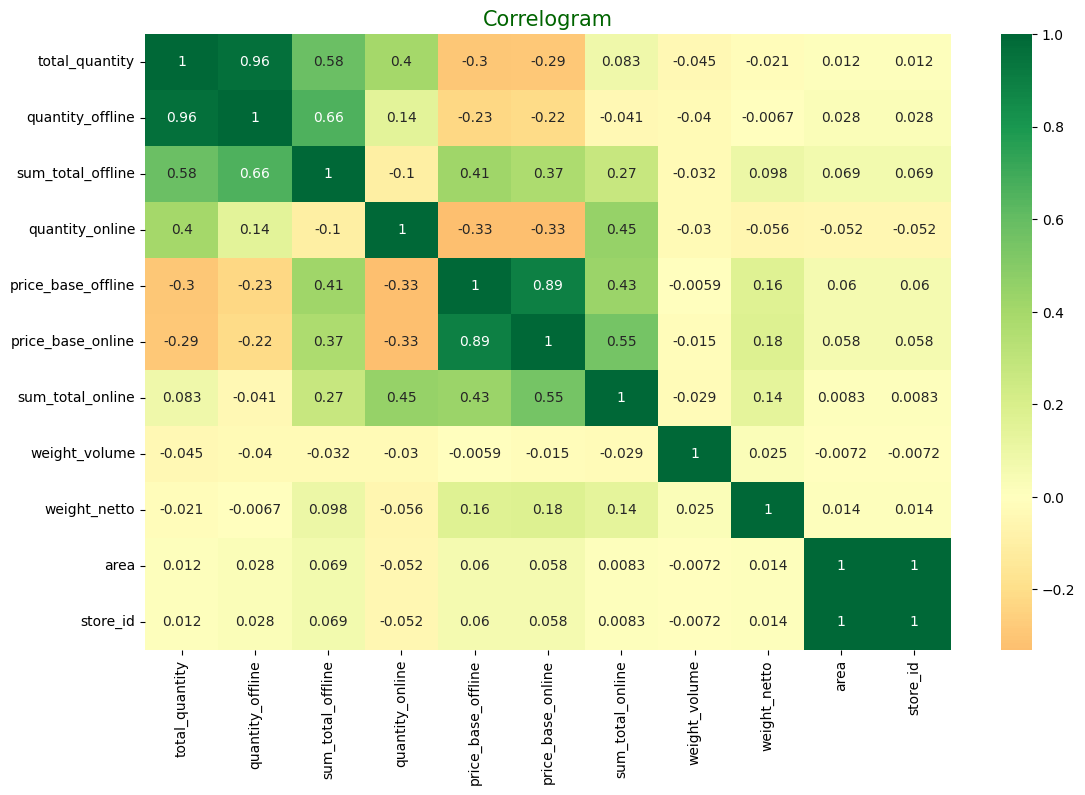

In [99]:
corr = train_set[list(corrs.index)].corr()

plt.figure(figsize = (13, 8))

sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)

plt.title('Correlogram', fontsize = 15, color = 'darkgreen')

plt.show()

In [100]:
# remove highly correlated coulumns
train_set = train_set.drop(columns=["area"])

In [101]:
features = train_set.select_dtypes(include="number").columns
features

Index(['quantity_offline', 'price_base_offline', 'sum_total_offline',
       'store_id', 'quantity_online', 'price_base_online', 'sum_total_online',
       'weight_volume', 'weight_netto', 'total_quantity'],
      dtype='object')

In [102]:
train_num_agg = train_set.groupby("item_id")[features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])

train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]

train_num_agg.reset_index(inplace = True)



# # Lag Features

for col in train_num_agg:

  if 'last' in col and col.replace('last', 'first') in train_num_agg:

    train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]

    train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]


In [103]:
train_set = train_set.merge(train_num_agg, how = 'inner', on = 'item_id')

In [104]:
test_num_agg = test_set.groupby("item_id")[features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])

test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

test_num_agg.reset_index(inplace = True)


# Lag Features

for col in test_num_agg:

  if 'last' in col and col.replace('last', 'first') in test_num_agg:

    test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]

    test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

In [105]:
test_set = test_set.merge(test_num_agg, how = 'inner', on = 'item_id')

In [106]:
# train.dropna(axis=1, how='all', inplace=True)
# test.dropna(axis=1, how='all', inplace=True)

train_set.fillna(-1, inplace=True)
test_set.fillna(-1, inplace=True)

In [107]:
df_train = train_set.copy()
df_test = test_set.copy()

<Axes: xlabel='fold'>

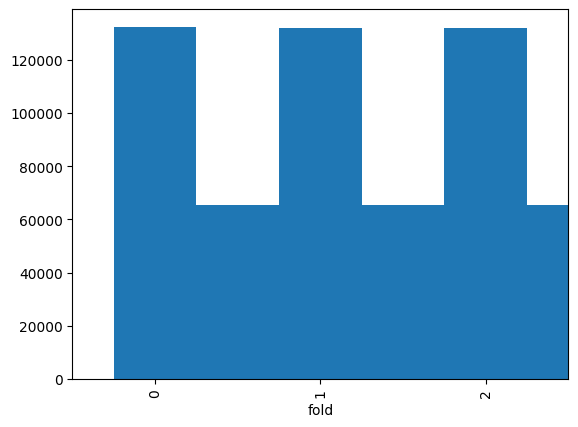

In [108]:
from sklearn.model_selection import StratifiedGroupKFold


# Sturge's rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df_train)))))



df_train['bins'] = pd.cut(df_train['total_quantity'], bins=num_bins, labels=False)

df_train['bins'].hist()

df_train['fold'] = -1



groups = np.array(df_train['item_id'].values)

N_FOLDS = 3

strat_kfold = StratifiedGroupKFold(n_splits=N_FOLDS, random_state=42, shuffle=True)

for i, (_, train_index) in enumerate(strat_kfold.split(df_train.index, df_train['bins'], groups=groups)):

    df_train.iloc[train_index, -1] = i



df_train['fold'] = df_train['fold'].astype('int')



df_train.fold.value_counts().plot.bar()

In [ ]:
import optuna
import xgboost as xgb

def objective_xgb(trial):

    """

    Optuna objective function. Returns

    the RMSE for an XGBoost model



    Assumes the training data are

    polars data frames

    """



    fold  = 0

    train_data = df_train[df_train.fold != fold].reset_index(drop=True)

    valid_data = df_train[df_train.fold == fold].reset_index(drop=True)



    xtrain, ytrain = train_data[features].fillna(-1), train_data.total_quantity

    xvalid, yvalid = valid_data[features].fillna(-1), valid_data.total_quantity





    dmat_train = xgb.DMatrix(xtrain, label = ytrain)

    dmat_valid = xgb.DMatrix(xvalid, label = yvalid)



#     # Suggest hyperparameters for XGBoost


    params = {'objective': 'reg:squarederror',

              'eval_metric': 'rmse',

              'seed': 19970507,

              'eta': trial.suggest_float("eta", 1e-2, 0.25, log = True),

              'max_depth': trial.suggest_int("max_depth", 1, 7),

              'lambda': trial.suggest_float("lambda", 1e-8, 100.0, log = True),

              'alpha': trial.suggest_float("alpha", 1e-8, 100.0, log = True),

             }



#     # To evaluate training progress (set verbose_eval = True)

    watchlist = [(dmat_train, 'train'), (dmat_valid, 'eval')]



    # Train the XGBoost model

    xgb_model = xgb.train(params,

                          dtrain = dmat_train,

                          num_boost_round = trial.suggest_int("num_boost_round", 20, 3000),

                          evals = watchlist,

                          verbose_eval = False)



    xgb_preds_valid = xgb_model.predict(dmat_valid)



    # Return the RMSE

    return mean_squared_error(yvalid, xgb_preds_valid, squared=False)

# Set up and run the Optuna study

study_xgb = optuna.create_study(direction = 'minimize')

study_xgb.optimize(objective_xgb, n_trials = 30)


[I 2025-01-14 13:24:06,272] A new study created in memory with name: no-name-c02e7dad-0f57-45d1-af17-1baec0399798
[I 2025-01-14 13:25:02,284] Trial 0 finished with value: 0.01173016420282834 and parameters: {'eta': 0.04823808184749829, 'max_depth': 7, 'lambda': 0.00015825520265292555, 'alpha': 4.1712355524813795e-05, 'num_boost_round': 1904}. Best is trial 0 with value: 0.01173016420282834.
[I 2025-01-14 13:25:37,396] Trial 1 finished with value: 0.01407636550408559 and parameters: {'eta': 0.03917056393137797, 'max_depth': 2, 'lambda': 2.7395973422944458e-05, 'alpha': 1.363824263236209e-06, 'num_boost_round': 1765}. Best is trial 0 with value: 0.01173016420282834.
[I 2025-01-14 13:26:29,700] Trial 2 finished with value: 0.01146641689978787 and parameters: {'eta': 0.10259587050808969, 'max_depth': 4, 'lambda': 1.093731689988767e-07, 'alpha': 0.06835337534100058, 'num_boost_round': 2141}. Best is trial 2 with value: 0.01146641689978787.
[I 2025-01-14 13:27:14,110] Trial 3 finished with v

In [ ]:
study_xgb.best_params